In [10]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import Lorenz96
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process
import jax
import matplotlib.pyplot as plt
#from jax_vi import KL_gaussian, log_likelihood
from jax.tree_util import Partial



# Parameters
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

J0 = 0
n = 40   # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R_matrix = 0.5 * jnp.eye(n)
R = jnp.array(R_matrix)  # Observation noise covariance
inv_R = inv(R)
H = jnp.eye(n)  # Observation matrix


N = 10
n_ensemble = 10
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [11]:
radius = 10
localization_matrix = generate_gc_localization_matrix(n, radius)
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
inflation = 1
e, c = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [12]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [13]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
   
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [14]:
var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0)

Array(104663.18, dtype=float32)

In [15]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [83]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring


# Modification: Use grad to compute the gradient with respect to the inflation parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.45 # Example starting value for inflation
alpha = 1e-6  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 20  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_gc_localization_matrix(n, radius)# jnp.ones((n, n)) # 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
errs = []
true_div = []

n_iters = 50
# from jax import config
# config.update("jax_debug_nans", True)

for i in tqdm(range(n_iters)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    
    inflations.append(inflation_opt)

    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)
    #clear_output(wait=True)
    print(inflation_opt)
    


  0%|          | 0/50 [00:00<?, ?it/s]

1.4058074 3.251297
1.4005333 3.1576862
1.3873091 2.9871006
1.3785582 2.882806
1.3689965 2.8229766
1.3664969 2.7434897
1.3634768 2.740265
1.3634485 2.74016
1.3628411 2.748786
1.3626473 2.7526739
1.3666636 2.7417054
1.3642249 2.7435408
1.3641044 2.7425494
1.3617388 2.7578032
1.3636719 2.7398648
1.3615032 2.7512746
1.3609564 2.7237675
1.3631144 2.7436047
1.3647087 2.7472963
1.364634 2.7468507
1.3612969 2.7422364
1.362422 2.7575212
1.3632771 2.741495
1.3612232 2.7389169
1.3633192 2.74102
1.3624403 2.757034
1.3625574 2.754505
1.3623466 2.7588456
1.361212 2.7381039
1.3620354 2.7609298
1.3638626 2.74092
1.3629439 2.7462568
1.3629171 2.746911
1.3624549 2.7569072
1.3607217 2.7085314
1.3603793 2.6877844
1.3683107 2.6992483
1.3668685 2.739131
1.3607733 2.71214
1.3610965 2.7319255
1.3579891 2.7056882
1.3593656 2.6775079
1.3615721 2.7533526
1.3626478 2.7525716
1.3641168 2.742632
1.3627014 2.7516794
1.3622682 2.7596135
1.3619765 2.760879
1.3640172 2.741794
1.3599048 2.6708853


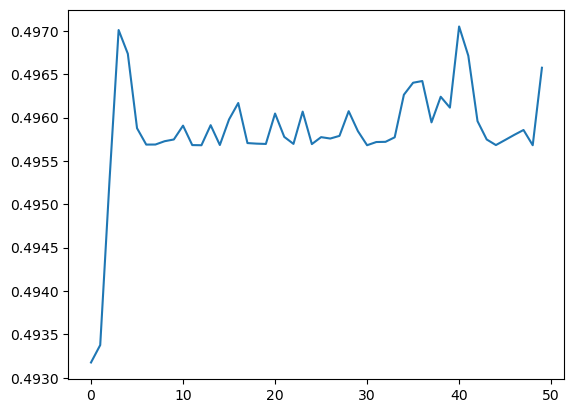

In [85]:
#plt.plot(inflations)
plt.plot(rmses)
#plt.plot(rmses)

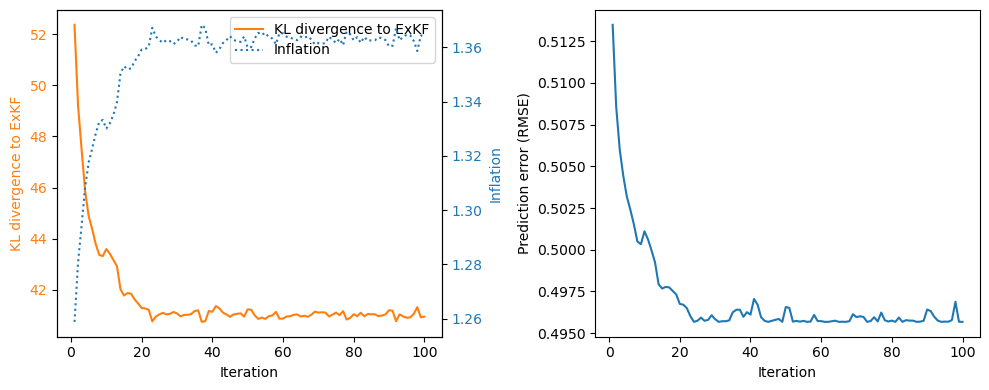

In [62]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:orange'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('KL divergence to ExKF', color=color)
ln1 = ax1.plot(range(1, n_iters+1), true_div, label='KL divergence to ExKF', color='tab:orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(range(1, n_iters+1), inflations, label='Inflation', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax3.plot(range(1, n_iters+1), rmses)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (RMSE)")

plt.tight_layout()
#plt.title('Inflation Parameter and Divergence from True Solution over Iterations')
#plt.show()
plt.savefig("inflation_errors.pdf")

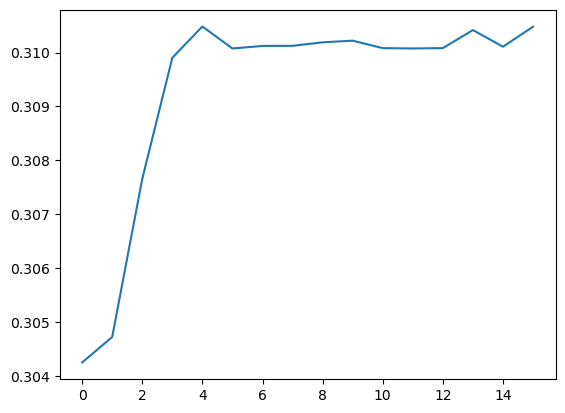

In [69]:
plt.plot(crpss)

In [76]:
[jnp.trace(C[i, :, :]) for i in range(250)]

[Array(8.655375, dtype=float32),
 Array(8.846758, dtype=float32),
 Array(8.905018, dtype=float32),
 Array(8.929239, dtype=float32),
 Array(8.945227, dtype=float32),
 Array(8.963932, dtype=float32),
 Array(8.981297, dtype=float32),
 Array(8.998209, dtype=float32),
 Array(9.012388, dtype=float32),
 Array(9.026248, dtype=float32),
 Array(9.040112, dtype=float32),
 Array(9.054729, dtype=float32),
 Array(9.072407, dtype=float32),
 Array(9.092963, dtype=float32),
 Array(9.111876, dtype=float32),
 Array(9.130459, dtype=float32),
 Array(9.145089, dtype=float32),
 Array(9.1635, dtype=float32),
 Array(9.177488, dtype=float32),
 Array(9.188932, dtype=float32),
 Array(9.193823, dtype=float32),
 Array(9.197152, dtype=float32),
 Array(9.199083, dtype=float32),
 Array(9.199834, dtype=float32),
 Array(9.199049, dtype=float32),
 Array(9.200311, dtype=float32),
 Array(9.198565, dtype=float32),
 Array(9.187269, dtype=float32),
 Array(9.173435, dtype=float32),
 Array(9.163664, dtype=float32),
 Array(9.161

In [79]:
jnp.trace(covariances[-1])

Array(2.7512746, dtype=float32)

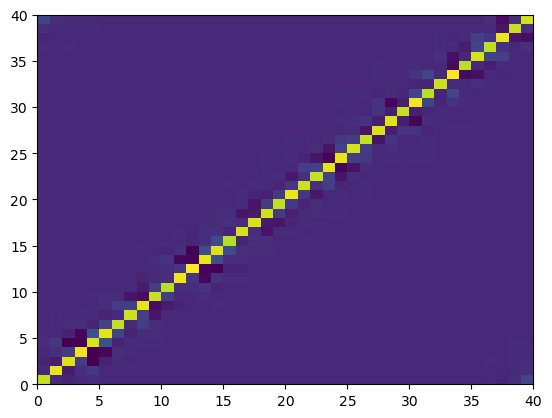

In [81]:
plt.pcolormesh(C[-1, :, :])

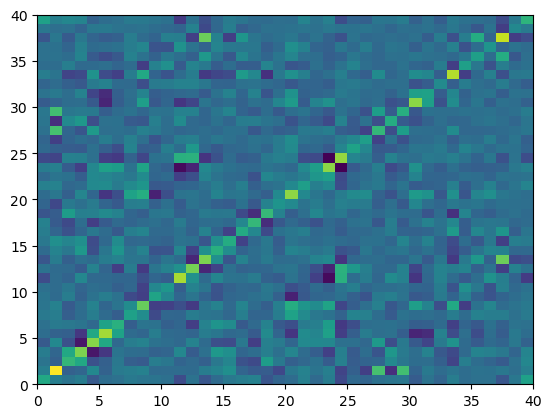

In [82]:
plt.pcolormesh(covariances[-1])

In [88]:
ins = []
cs = []
ds = []

for i in jnp.arange(1.0, 2.0, 0.01):
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, i, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t/num_steps

    c = var_cost(i, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    print(i, c, total_kl_divergence)
    cs.append(c)
    ds.append(total_kl_divergence)
    ins.append(i)

1.0 104666.266 411.19836
1.01 100496.99 394.5053
1.02 95442.38 374.26587
1.03 88935.516 348.2102
1.04 80638.44 314.98398
1.05 71267.41 277.44864
1.06 62313.438 241.56467
1.0699999 54353.0 209.63753
1.0799999 47277.293 181.23422
1.0899999 40926.805 155.71083
1.0999999 35803.723 135.04678
1.1099999 32213.67 120.44476
1.1199999 29509.238 109.30671
1.1299999 27307.348 100.08535
1.1399999 25563.078 92.615814
1.1499999 24092.871 86.19001
1.1599998 22898.652 80.842834
1.1699998 21853.215 76.0479
1.1799998 20980.988 71.91513
1.1899998 20288.305 68.50444
1.1999998 19665.006 65.34691
1.2099998 19114.541 62.426975
1.2199998 18649.21 59.820274
1.2299998 18266.91 57.550533
1.2399998 17959.62 55.62536
1.2499998 17700.572 53.85644
1.2599998 17468.734 52.18306
1.2699997 17275.709 50.666397
1.2799997 17120.65 49.283714
1.2899997 16992.264 48.07934
1.2999997 16887.441 46.804146
1.3099997 16814.225 45.678284
1.3199997 16748.787 44.655117
1.3299997 16695.447 43.591984
1.3399997 16675.705 42.879433
1.34999

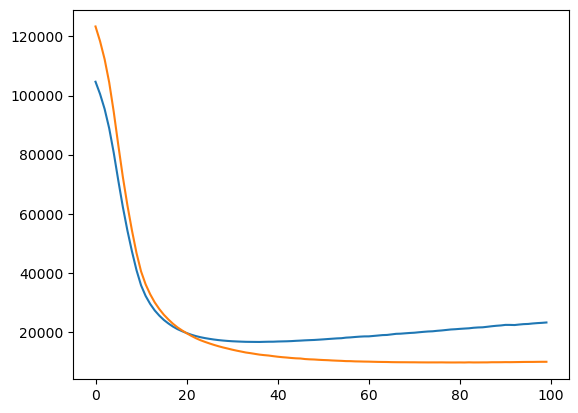

In [94]:
plt.plot(cs)
plt.plot(jnp.array(ds)*300)

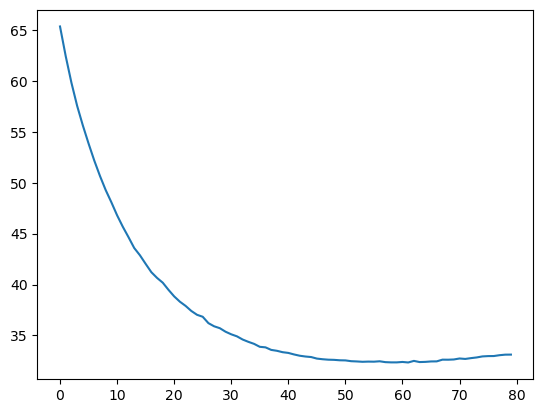

In [96]:
plt.plot(ds[20:])